In [1]:
import pandas as pd
import numpy as np
import re
import pickle

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer

d:\APPS\Anaconda\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Part 1 Get the corpus

In [2]:
# get all the unique names and store them in a list
character_metadata = pd.read_csv('../data/character.metadata.tsv', sep='\t', header=None)
character_metadata.columns = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_release_date',
    'character_name',
    'actor_dob',
    'actor_gender',
    'actor_height',
    'actor_ethnicity',
    'actor_name',
    'actor_age',
    'freebase_character_map_1',
    'freebase_character_map_2',
    'freebase_character_map_3'
]
character_metadata = character_metadata.dropna(subset=['character_name'])

In [14]:
PLOT_SUMMARY_PATH = "../data/resolved_texts_fastcoref.csv"

plot_summaries = pd.read_csv(PLOT_SUMMARY_PATH)
display(plot_summaries)
wiki_ids = plot_summaries['wiki_id'].unique().tolist()

,wiki_id,resolved_text
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six year...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev looks..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [18]:
character_discriptions = {}
for wiki_id in wiki_ids:
    character_discriptions[wiki_id] = {}
    unique_characters = character_metadata[character_metadata['wikipedia_movie_id'] == wiki_id]['character_name'].unique().tolist()
    unique_characters = [character.split(' ')[0] for character in unique_characters if type(character) == str]

    movie_description = plot_summaries[plot_summaries['wiki_id'] == wiki_id]['resolved_text'].values[0]

    # split the description into sentences. sentences are separated by . ? ! ...
    movie_sentences = re.split('[.!?...]', movie_description)
    for character in unique_characters:
        
        character_discriptions[wiki_id][character] = []
        for sentence in movie_sentences:
            if character in sentence:
                character_discriptions[wiki_id][character].append(sentence)
        character_discriptions[wiki_id][character] = ' '.join(character_discriptions[wiki_id][character])


In [20]:
data = []

for wiki_id, characters in character_discriptions.items():
    for character_name, character_description in characters.items():
        data.append({
            'wiki_id': wiki_id,
            'character_name': character_name,
            'character_description': character_description
        })

# Create a DataFrame from the list of dictionaries
character_descriptions_df = pd.DataFrame(data)

display(character_descriptions_df)

character_descriptions_df.to_csv('../data/character_descriptions.csv', index=False)

,wiki_id,character_name,character_description
0,31186339,Foxface,"Foxface, the girl from District 5, dies from ..."
1,31186339,Katniss,Her older sister Katniss volunteers to take h...
2,31186339,Peeta,"Peeta Mellark, a baker's son who once gave Ka..."
3,31186339,Effie,
4,31186339,Gale,
...,...,...,...
134908,8628195,Amina,"Abdur Rehman Khan , a middle-aged dry fruit se..."
134909,8628195,Neelam,
134910,8628195,Raj,
134911,8628195,Manoj,


### Part 2 T-SNE visualization

In [2]:
DATA_PATH = "../data/character_descriptions.csv"
data = pd.read_csv(DATA_PATH)
display(data.head(3))
data.shape

,wiki_id,character_name,character_description
0,31186339,Foxface,"Foxface, the girl from District 5, dies from ..."
1,31186339,Katniss,Her older sister Katniss volunteers to take h...
2,31186339,Peeta,"Peeta Mellark, a baker's son who once gave Ka..."


(134913, 3)

In [3]:
data = data.dropna(subset=['character_description'])
data.shape

(57890, 3)

In [4]:
# embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
# use gpu if available
device = 'cuda'
model.to(device)
character_descriptions = data['character_description'].values.tolist()
character_list = data['character_name'].values.tolist()
description_embeddings = model.encode(character_descriptions, show_progress_bar=True)
embedding_result = {"embedding": description_embeddings, "character": character_list}
with open('../generated/description_embeddings.pickle', 'wb') as handle:
    pickle.dump(embedding_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

Batches: 100%|██████████| 1810/1810 [08:35<00:00,  3.51it/s]


In [6]:
# load embeddings
with open('../generated/description_embeddings.pickle', 'rb') as handle:
    embedding_result = pickle.load(handle)

X = embedding_result['embedding']
y = embedding_result['character']

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 57890 samples in 0.045s...
[t-SNE] Computed neighbors for 57890 samples in 19.758s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57890
[t-SNE] Computed conditional probabilities for sample 2000 / 57890
[t-SNE] Computed conditional probabilities for sample 3000 / 57890
[t-SNE] Computed conditional probabilities for sample 4000 / 57890
[t-SNE] Computed conditional probabilities for sample 5000 / 57890
[t-SNE] Computed conditional probabilities for sample 6000 / 57890
[t-SNE] Computed conditional probabilities for sample 7000 / 57890
[t-SNE] Computed conditional probabilities for sample 8000 / 57890
[t-SNE] Computed conditional probabilities for sample 9000 / 57890
[t-SNE] Computed conditional probabilities for sample 10000 / 57890
[t-SNE] Computed conditional probabilities for sample 11000 / 57890
[t-SNE] Computed conditional probabilities for sample 12000 / 57890
[t-SNE] Computed conditional probabilities for s

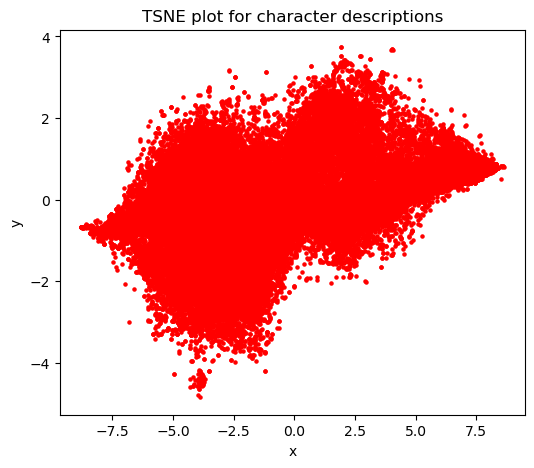

In [7]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c='red', s=5)
plt.title('TSNE plot for character descriptions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### LDA result

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.models import TfidfModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [11]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ke\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [41]:
def pre_processing(str):
    # remove the line terminators
    str = re.sub(r'\n', ' ', str)

    # Remove stop words
    stop_words = stopwords.words('english')
    str = " ".join([word for word in str.split() if word not in stop_words])

    # remove 's
    str = re.sub(r"'s", '', str)
    
    # Remove punctuation
    str = re.sub(r'[^\w\s]', '', str)

    # Remove numbers
    str = re.sub(r'\d+[^\w]', ' ', str)

    # Keep the words that are adjectives or nouns or verbs
    allowed_postags=['JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NN', 'NNS']
    str = " ".join([word for word, pos in nltk.pos_tag(str.split()) if pos in allowed_postags])

    # Convert to lowercase
    str = str.lower()

    # Lemmatize
    # lemmatizer = WordNetLemmatizer()
    # str = " ".join([lemmatizer.lemmatize(word) for word in str.split()])

    return str

In [36]:
DATA_PATH = "../data/character_descriptions.csv"
data = pd.read_csv(DATA_PATH)
data = data.dropna(subset=['character_description'])
display(data.head(3))
data.shape

,wiki_id,character_name,character_description
0,31186339,Foxface,"Foxface, the girl from District 5, dies from ..."
1,31186339,Katniss,Her older sister Katniss volunteers to take h...
2,31186339,Peeta,"Peeta Mellark, a baker's son who once gave Ka..."


(57890, 3)

In [42]:
data['character_description'] = data['character_description'].astype(str)
data['description_cleaned'] = data['character_description'].apply(lambda x: pre_processing(x))

In [43]:
data['description_cleaned'].head()

0    girl dies eating nightlock berries stole knew ...
1    older sister volunteers take place baker son g...
2    baker son gave bread starving tribute taken ac...
5    taken accompanied drunk mentor victor televise...
6    ambushes pins gloats tribute kills overhearing...
Name: description_cleaned, dtype: object

In [44]:
# store the cleaned data in a list
doc_words = [doc.split() for doc in data['description_cleaned'] if len(doc)>5]
# remove too short words
doc_words = [[word for word in doc if len(word)>2] for doc in doc_words]

# Remove words that occur in less than 10 documents, and words that occur in more than 95% of the documents
dictionary = Dictionary(doc_words)
dictionary.filter_extremes(no_below=10, no_above=0.95)
print(dictionary)

# Transform each document to a vectorized form by computing the TF/IDF of each word in each document
corpus = [dictionary.doc2bow(doc) for doc in doc_words]
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
print([[(dictionary[id], freq) for id, freq in cp] for cp in corpus_tfidf[:1]])

Dictionary<14055 unique tokens: ['berries', 'dies', 'eating', 'girl', 'knew']...>
[[('berries', 0.5745316077412468), ('dies', 0.24386387175982138), ('eating', 0.3405345601959664), ('girl', 0.19280333094991955), ('knew', 0.31922873883948955), ('poisonous', 0.49126056015998093), ('stole', 0.3377321527091758)]]


In [45]:
# Apply LDA with different K values and find the optimal number of topics based on the topic coherence measure
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        alpha='auto',
                        eta='auto',
                        passes=10,
                        iterations=10,
                        eval_every=None,
                        random_state=12345)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=doc_words, start=5, limit=41, step=5)

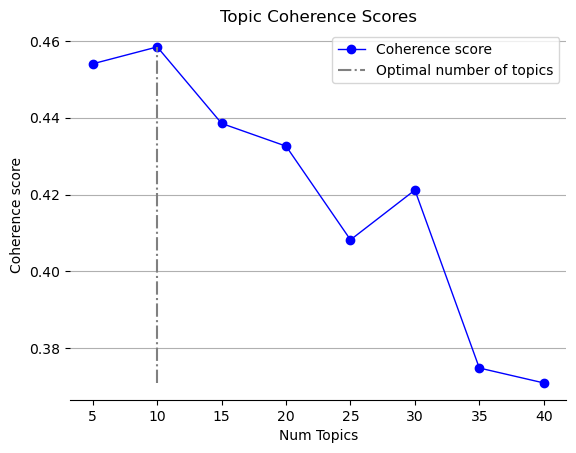

In [48]:
# Plot a curve showing topic coherence vs number of topics
limit=41; start=5; step=5;
x = range(start, limit, step)
best_model_index = coherence_values.index(max(coherence_values))
num_topics = x[best_model_index]
ymin = min(coherence_values)
ymax = max(coherence_values)

# Show graph
plt.plot(x, coherence_values, marker='o', color='blue', linewidth=1, label='Coherence score')
plt.vlines(x=num_topics, ymin=ymin, ymax=ymax, colors='gray', linestyles='-.', label='Optimal number of topics')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.grid(True, which='major', axis='y')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.title('Topic Coherence Scores')
plt.legend()
plt.show()

In [49]:
# Examine the topics found by the best model
# get the topic number with the highest coherence score
best_model_index = coherence_values.index(max(coherence_values))
best_model = model_list[best_model_index]
pprint(best_model.print_topics())

# save the best model
best_model.save('../generated/lda_model')

[(0,
  '0.032*"town" + 0.023*"local" + 0.022*"gang" + 0.020*"murder" + '
  '0.020*"police" + 0.018*"train" + 0.016*"hotel" + 0.014*"killed" + '
  '0.013*"case" + 0.012*"revenge"'),
 (1,
  '0.028*"friend" + 0.022*"wife" + 0.018*"young" + 0.018*"named" + '
  '0.018*"meets" + 0.016*"man" + 0.015*"woman" + 0.015*"relationship" + '
  '0.015*"becomes" + 0.015*"daughter"'),
 (2,
  '0.036*"car" + 0.018*"police" + 0.018*"kill" + 0.014*"gun" + 0.014*"men" + '
  '0.013*"shoots" + 0.013*"kills" + 0.012*"shot" + 0.011*"killed" + '
  '0.009*"killing"'),
 (3,
  '0.022*"tells" + 0.016*"get" + 0.015*"home" + 0.013*"house" + 0.013*"goes" + '
  '0.012*"day" + 0.011*"time" + 0.010*"gets" + 0.010*"night" + 0.010*"asks"'),
 (4,
  '0.061*"money" + 0.022*"prison" + 0.017*"business" + 0.015*"brothers" + '
  '0.015*"pay" + 0.014*"officer" + 0.012*"deal" + 0.011*"bank" + 0.011*"jail" '
  '+ 0.011*"plan"'),
 (5,
  '0.010*"escape" + 0.009*"group" + 0.009*"fight" + 0.008*"help" + '
  '0.007*"find" + 0.007*"save" + 

In [50]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.102698  0.119463       1        1  24.612037
5     -0.107506  0.097748       2        1  12.823253
1      0.233233 -0.063121       3        1  12.370430
6      0.237209 -0.084375       4        1  10.227903
7      0.129001 -0.081792       5        1   9.174893
8     -0.038416  0.219013       6        1   9.141659
2     -0.242351  0.097636       7        1   6.614872
9      0.031724  0.122491       8        1   6.526658
0     -0.180018 -0.069697       9        1   4.829761
4     -0.165574 -0.357366      10        1   3.678534, topic_info=          Term          Freq         Total Category  logprob  loglift
84        love   9816.000000   9816.000000  Default  30.0000  30.0000
424     family   8290.000000   8290.000000  Default  29.0000  29.0000
150      tells  12465.000000  12465.000000  Default  28.0000  28.0000
535      money   5054.000000   5054.000000  Default  27.0000  27.0000
238       life   8189.000000   8189.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1073     steal    602.380508    981.550980  Topic10  -4.9298   2.8144
610       plan    909.396703   2802.659517  Topic10  -4.5179   2.1771
411   arrested    612.673791   1547.065310  Topic10  -4.9128   2.3764
1217    enough    407.515158    670.081433  Topic10  -5.3206   2.8053
277     police    480.565288   5402.393671  Topic10  -5.1557   0.8830

[623 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
868       8  0.999107  accident
786      10  0.996531   account
5457      9  0.997320   accused
632       1  0.062239       act
632       2  0.007544       act
...     ...       ...       ...
395       3  0.932772     young
395       4  0.066209     young
395       8  0.000914     young
631       4  0.999632   younger
2912      8  0.995875  youngest

[1369 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 7, 8, 9, 3, 10, 1, 5])

In [52]:
# save the visualization to a html file
save_path = '../generated/lda_vis.html'
pyLDAvis.save_html(vis, save_path)